In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
import tcripser
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ase
from ase.io import cube
from ase.io import cif
import multiprocessing
from multiprocessing.dummy import Pool
import pickle
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [19]:
inDir="Z:/data/diverse_metals"
topTypes=os.listdir(inDir+"/diverseTop")


In [4]:
topTypes=['tFunc', 'tThresh-05', 'tThresh0']

In [12]:
fName="DB12-SEHZUB_clean_PH" #


## Let's plot some PH
- find relatively good bounds to discretize

In [13]:
diags=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)

In [24]:
len(diags[2])

2347

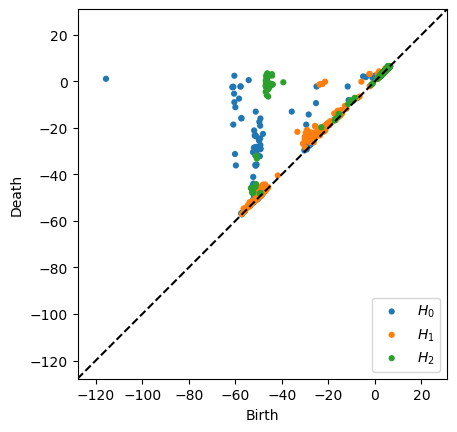

In [17]:
#saveDir=

persim.plot_diagrams(list(diags))
plt.savefig(f"{inDir}/{fName[:-3]}.png")

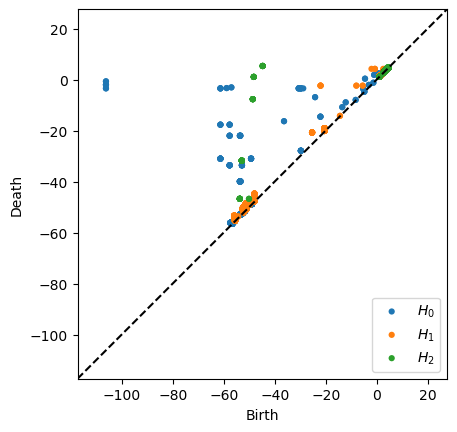

In [11]:
persim.plot_diagrams(list(diags))

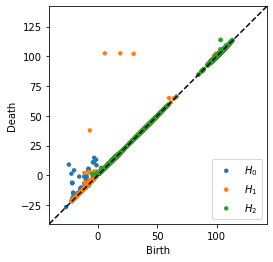

In [7]:
fName="DB7-ddmof_15992_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

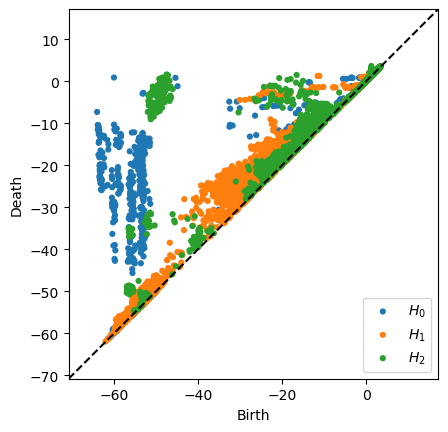

In [12]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

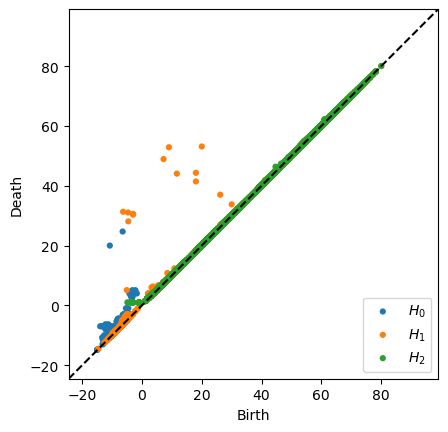

In [8]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

# Let's grab some outliars in the data and see if they have any apparent patterns

In [20]:

df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)
np.random.seed(42)

# grab 4 bins for each, trP% of samples within regions
##
## workingCap: [0-1,1-2,2-4,4-]
## selectivity: [0-50,50-200,200-400,400-]
trP=.70
totalLen=len(df['selectivity'])
regVars=['selectivity','mmol/g_working_capacity']
bounds={"selectivity":[(0,50),(50,200),(200,400),(400,)],"mmol/g_working_capacity":[(0,1),(1,2),(2,4),(4,)]}

indexBounds={k:[] for k in bounds.keys()} #upper index for

for k in regVars:
    j=0
    bj=0
    for index,row in df.sort_values(by=[k]).iterrows():
        if bj>=len(bounds[k])-1:
            break
        elif row[k]>bounds[k][bj][1]:
            indexBounds[k].append(j)
            bj+=1
        j+=1


np.random.seed(42)
testBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[:indexBounds[k][j]],size=round((1-trP)*indexBounds[k][j]),replace=False)))
    for j in range(1,len(indexBounds[k])):
        testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]],size=round((1-trP)*(indexBounds[k][j]-indexBounds[k][j-1])),replace=False)))
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][-1]:],size=round((1-trP)*(totalLen-indexBounds[k][-1])),replace=False)))



trainBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[:indexBounds[k][j]])-set(testBins[k][j])))
    for j in range(1,len(indexBounds[k])):
        trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]])-set(testBins[k][j])))
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][-1]:])-set(testBins[k][-1])))



In [8]:
PHvec=np.zeros(tBins+4,dtype=np.int32)
"""PHvec is frequency projection to:
First 4 elements cover outside bounds [#belowPersistent,#abovePersistent,belowWeak,aboveWeak, ...]
the rest of PHvec, PHvec[4:] is a vertical, then right sweep of the bounding triangle

each [b,d] pair maps to a projection of the number of points within that region
PHvec[4:]=[in(-25,-25),in(-25,-24),..,in(-25,50),...,in(50,50)]
"""



'PHvec is frequency projection to:\nFirst 4 elements cover outside bounds [#belowPersistent,#abovePersistent,belowWeak,aboveWeak, ...]\nthe rest of PHvec, PHvec[4:] is a vertical, then right sweep of the bounding triangle\n\neach [b,d] pair maps to a projection of the number of points within that region\nPHvec[4:]=[in(-25,-25),in(-25,-24),..,in(-25,50),...,in(50,50)]\n'

In [5]:
bounds={"selectivity":300,"mmol/g_working_capacity":3.75}

selectAll=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [6]:
len(selectAll)

21

In [36]:
selectAll

,filename,mmol/g_working_capacity,selectivity
1033,DB12-NEYZAU_clean,4.727319,564.061035
1109,DB12-IQEKOG_clean,5.701334,327.561420
2027,DB12-CUZBUW_clean,3.842521,300.440480
2158,DB12-LOBHAM_clean,5.786555,309.539870
2808,DB12-SERWAP_freeONLY,4.967852,309.405780
2858,DB5-hypotheticalMOF_5081767_0_0_2_29_1_14,5.144488,311.509245
3315,DB5-hypotheticalMOF_22163_0_0_1_11_10_13,4.884263,324.403595
3461,DB12-NAWKII_clean,3.905228,304.836540
4983,DB5-hypotheticalMOF_5050675_0_0_1_23_3_12,3.792218,351.761515
5018,DB1-Zn2O8-fum_A-irmof20_A_No142,7.928258,336.277145


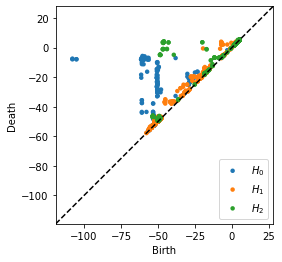

In [7]:
fName="DB12-TOXNIF_clean"
diags2=np.load(f"{inDir}/{topTypes[0]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

In [2]:
fName="DB12-CUZBUW_clean"
diags1=np.load(f"{inDir}/{topTypes[0]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

NameError: name 'inDir' is not defined

In [ ]:
#side by side

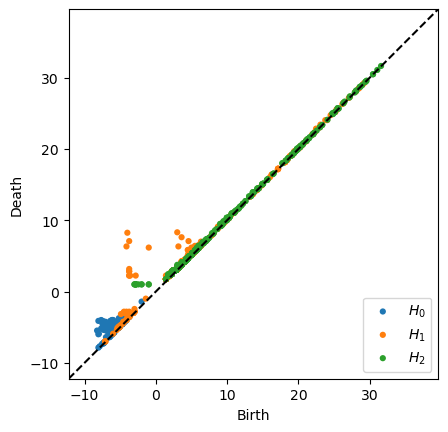

In [110]:
fName="DB12-TOXNIF_clean"
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

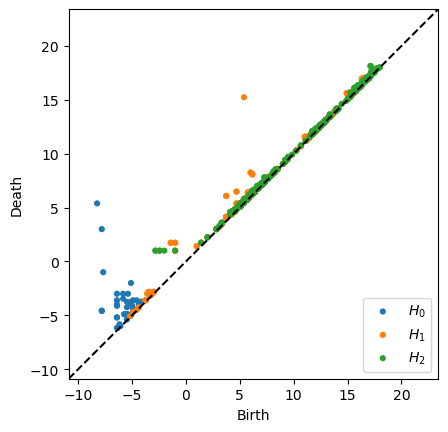

In [11]:
fName="DB12-CUZBUW_clean"
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

In [12]:
diags1

array([array([[-6.324555320336759, -6.164414002968976],
              [-6.4031242374328485, -6.164414002968976],
              [-6.082762530298219, -6.0],
              [-6.164414002968976, -5.830951894845301],
              [-5.477225575051661, -5.385164807134504],
              [-6.4031242374328485, -5.196152422706632],
              [-6.4031242374328485, -5.196152422706632],
              [-5.0990195135927845, -5.0],
              [-5.385164807134504, -4.898979485566356],
              [-5.477225575051661, -4.898979485566356],
              [-5.656854249492381, -4.898979485566356],
              [-5.744562646538029, -4.898979485566356],
              [-4.898979485566356, -4.58257569495584],
              [-7.810249675906654, -4.58257569495584],
              [-7.810249675906654, -4.58257569495584],
              [-4.898979485566356, -4.47213595499958],
              [-4.58257569495584, -4.47213595499958],
              [-4.58257569495584, -4.47213595499958],
              [-5.477225

In [15]:
maxesb0={k:np.array([np.max(np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)[0]) for fName in df["filename"]]) for k in topTypes}

KeyboardInterrupt: 

In [ ]:
maxesb2={k:np.array([np.max(np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)[2]) for fName in df["filename"]]) for k in topTypes}

In [18]:
bounds0={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}
bounds1={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}
bounds2={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}

for k in topTypes:
    i=0
    for fName in df["filename"]:
        dat=np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)
        bounds0[k][0][i]=np.min(dat[0])
        bounds0[k][1][i]=np.max(dat[0])
        bounds1[k][0][i]=np.min(dat[1])
        bounds1[k][1][i]=np.max(dat[1])
        bounds2[k][0][i]=np.min(dat[2])
        bounds2[k][1][i]=np.max(dat[2])
        i+=1

In [33]:
bounds1={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}


for k in topTypes:
    i=0
    for fName in df["filename"]:
        dat=np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)
        bounds1[k][0][i]=np.min(dat[1])
        bounds1[k][1][i]=np.max(dat[1])

        #bounds2[k][0][i]=np.min(dat[2])
        #bounds2[k][1][i]=np.max(dat[2])
        i+=1

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-152.04285413, -151.87287033, -151.70288654, ...,   17.6009736 ,
          17.77095739,   17.94094119]),
 <a list of 2 BarContainer objects>)

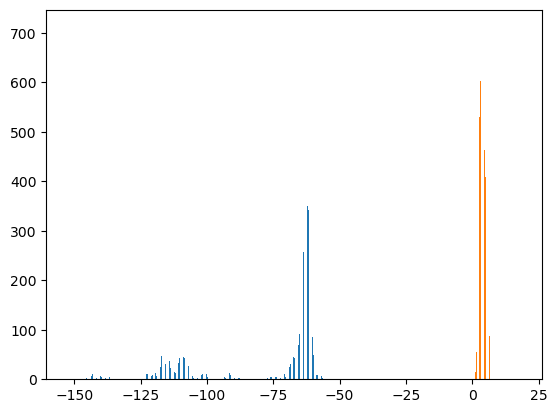

In [19]:
plt.hist(bounds0['tFunc'],bins=1000)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-74.67679458, -74.57790385, -74.47901311, ...,  24.01616071,
         24.11505145,  24.21394218]),
 <a list of 2 BarContainer objects>)

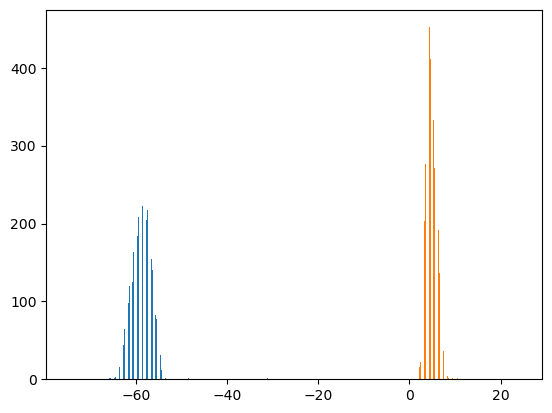

In [53]:
plt.hist(bounds1['tFunc'],bins=1000)

(array([[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-37.2424489 , -37.07719864, -36.91194838, ..., 127.67731174,
        127.842562  , 128.00781226]),
 <a list of 2 BarContainer objects>)

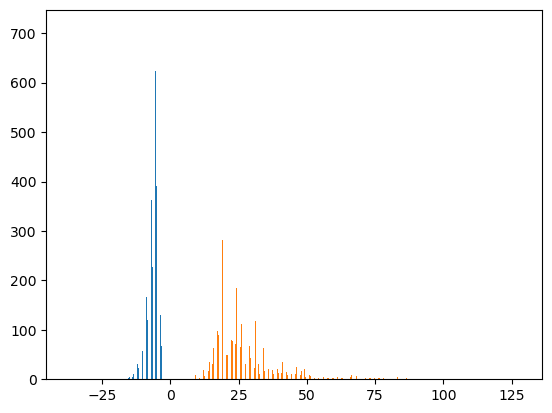

In [56]:
plt.hist(bounds1[topTypes[2]],bins=1000)

In [57]:
topTypes

['tFunc', 'tThresh-05', 'tThresh0']

In [27]:
max(bounds0[topTypes[2]][1])

103.0

In [31]:
sum([1 for i in bounds0[topTypes[2]][1] if i>20])

198

ValueError: x must have 2 or fewer dimensions

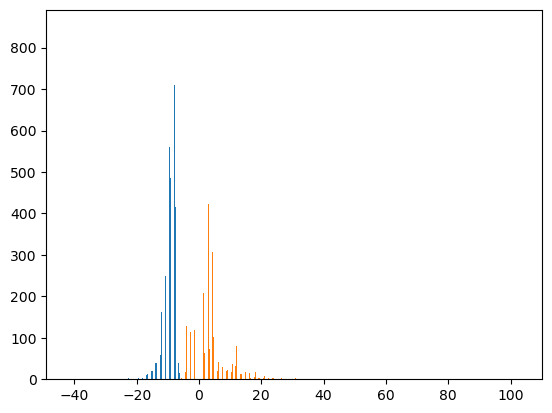

In [21]:
plt.hist(plt.hist(bounds0[topTypes[2]],bins=1000))

ValueError: x must have 2 or fewer dimensions

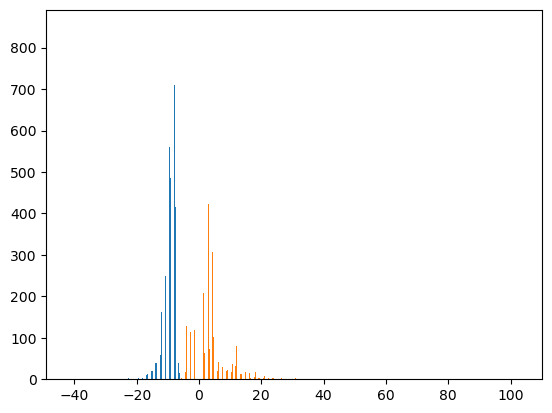

In [32]:
plt.hist(plt.hist(bounds0[topTypes[1]],bins=1000))

ValueError: x must have 2 or fewer dimensions

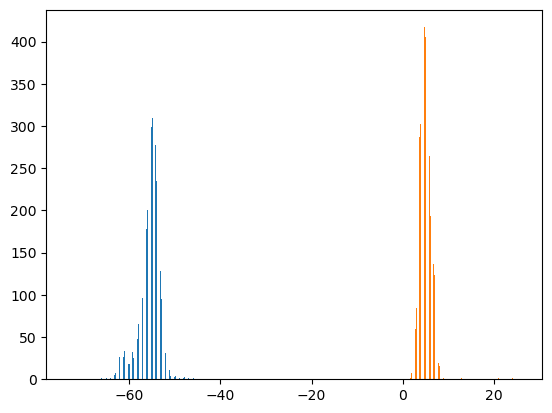

In [24]:
plt.clf()
plt.hist(plt.hist(bounds2[topTypes[0]],bins=1000))

ValueError: x must have 2 or fewer dimensions

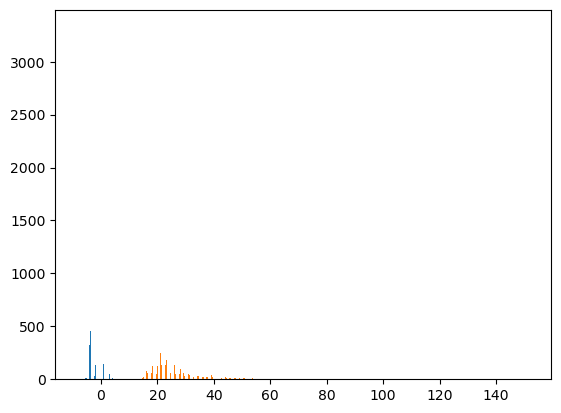

In [23]:
plt.clf()
plt.hist(plt.hist(bounds2[topTypes[2]],bins=1000))

ValueError: x must have 2 or fewer dimensions

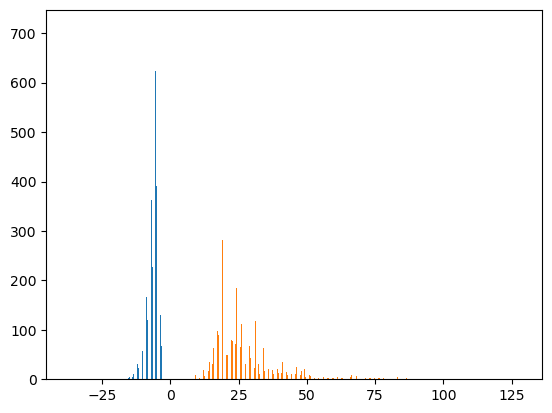

In [119]:
plt.clf()
plt.hist(plt.hist(bounds1[topTypes[2]],bins=1000))

In [48]:
np.random.seed(42)
randMof=np.random.choice(len(df["filename"]),size=150,replace="False")

In [49]:
randMof

array([ 7270,   860,  5390,  5191, 11964, 11284,  5734,  6265,   466,
        4426,  5578, 11636, 11363, 11111,  8322,  1685,   769, 10583,
        6949,  2433,  5311,  5051,  6420,  1184,  4555,  3385,  6396,
       11096,  8666,  9274,  2558,  7849,  2047,  2747,  9167,  9998,
         189,  2734,  3005,  4658,  1899,  7734,  1267,  1528, 11394,
        3556,  3890,  8838, 11080,  5393, 10627,  8792, 10555, 10253,
        8433, 10233, 11016,  7513,  2612,  7041,  9555,  6235,  5486,
        7099,  9670, 10748,   775,  8226,  3152, 10147,  1585,  3943,
        7555,  3073,  1021, 11653, 10805,  3843,  7989,  9692,  6873,
        5675,   161,  4297, 10173,   995, 11534,  7629, 11990,  9467,
        1016,  7869,  6439,  7892,  6863,  7916,  8529,   878,  9268,
        4887, 12185,  4859,  6331,  8571,  8684,  7208,  5276,  2062,
       12076,    64,  8006,  2568,  5463,  2027,  2695,  9687,  5258,
        5618,  6736,   391,  5892,  3561, 10470,  6184,  3099,  6278,
        8392,  3104,

In [50]:
subMof=df.iloc(0)[randMof]

In [58]:
subMof

,filename,mmol/g_working_capacity,selectivity
7270,DB0-m3_o153_o22_f0_fsc.sym.61,2.397933,166.126460
860,DB12-VULKIX_clean,1.462808,144.082065
5390,DB5-hypotheticalMOF_5055689_1_0_1_28_15_5,0.180313,1.422015
5191,DB0-m3_o14_o22_f0_pcu.sym.99,1.779169,97.214630
11964,DB12-WUXLEI_clean,1.323712,35.411010
...,...,...,...
6938,DB0-m3_o160_o1510_f0_fsc.sym.43,0.725963,24.163015
4488,DB0-m2_o16_o26_f0_pcu.sym.24,0.709071,17.543560
206,DB12-XIHXET_clean,1.321507,213.972265
5134,DB0-m3_o96_o11_f0_fsc.sym.9,1.414569,39.404695


(array([76., 33., 12., 14.,  5.,  3.,  3.,  2.,  1.,  1.]),
 array([  0.545795,  38.940459,  77.335123, 115.729787, 154.124451,
        192.519115, 230.913779, 269.308443, 307.703107, 346.097771,
        384.492435]),
 <BarContainer object of 10 artists>)

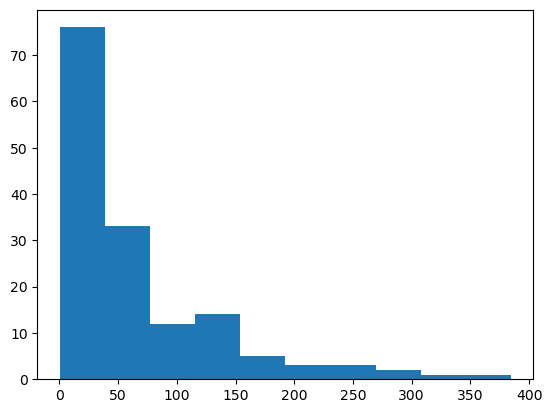

In [51]:
plt.hist(subMof["selectivity"])

(array([55., 27., 27., 15., 13.,  5.,  4.,  2.,  1.,  1.]),
 array([0.020213 , 0.5414606, 1.0627082, 1.5839558, 2.1052034, 2.626451 ,
        3.1476986, 3.6689462, 4.1901938, 4.7114414, 5.232689 ]),
 <BarContainer object of 10 artists>)

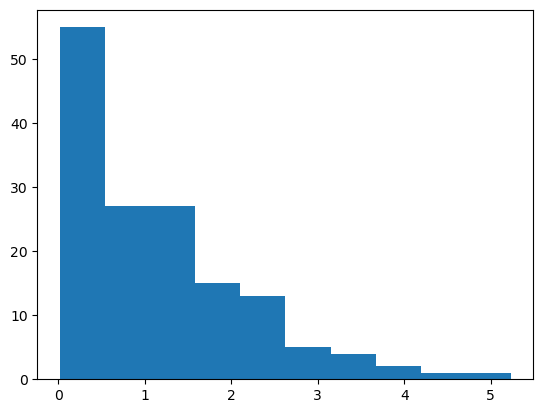

In [52]:
plt.hist(subMof["mmol/g_working_capacity"])

In [89]:
def wDist(mof1,mof2,b): ###SLOW! change to csv format
    return persim.wasserstein(np.load(f"{inDir}/{topTypes[2]}/{mof1}_PH.npy",allow_pickle=True)[b].astype("float64"),np.load(f"{inDir}/{topTypes[2]}/{mof2}_PH.npy",allow_pickle=True)[b].astype("float64"))

def bDist(mof1,mof2,b): ###SLOW! change to csv format
    return persim.bottleneck(np.load(f"{inDir}/{topTypes[2]}/{mof1}_PH.npy",allow_pickle=True)[b].astype("float64"),np.load(f"{inDir}/{topTypes[2]}/{mof2}_PH.npy",allow_pickle=True)[b].astype("float64"))

In [161]:
selectAll

,filename,mmol/g_working_capacity,selectivity
1033,DB12-NEYZAU_clean,4.727319,564.061035
1109,DB12-IQEKOG_clean,5.701334,327.561420
2027,DB12-CUZBUW_clean,3.842521,300.440480
2158,DB12-LOBHAM_clean,5.786555,309.539870
2808,DB12-SERWAP_freeONLY,4.967852,309.405780
2858,DB5-hypotheticalMOF_5081767_0_0_2_29_1_14,5.144488,311.509245
3315,DB5-hypotheticalMOF_22163_0_0_1_11_10_13,4.884263,324.403595
3461,DB12-NAWKII_clean,3.905228,304.836540
4983,DB5-hypotheticalMOF_5050675_0_0_1_23_3_12,3.792218,351.761515
5018,DB1-Zn2O8-fum_A-irmof20_A_No142,7.928258,336.277145


In [90]:

wDist(selectAll['filename'].iloc(0)[0],selectAll['filename'].iloc(0)[1],b=2)

251.8761475692359

In [95]:
bDist(selectAll['filename'].iloc(0)[0],selectAll['filename'].iloc(0)[1],b=0)

4.16227766016838

In [66]:
selectAll['filename'].iloc(0)[0]

'DB12-NEYZAU_clean'

In [97]:
subMof['filename'].iloc(0)[0]

'DB0-m3_o153_o22_f0_fsc.sym.61'

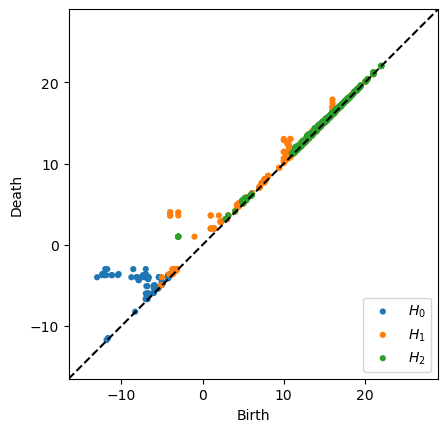

In [162]:

fName='DB1-Zn2O8-fum_A-irmof20_A_No142'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

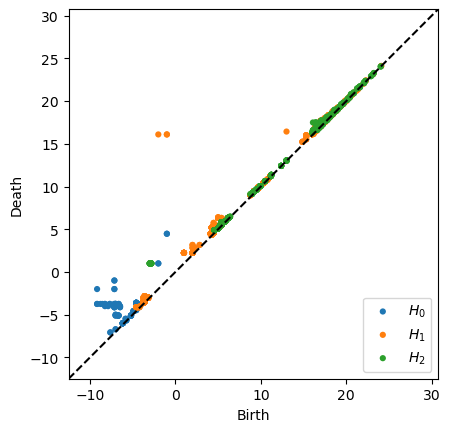

In [103]:
fName='DB12-NEYZAU_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))



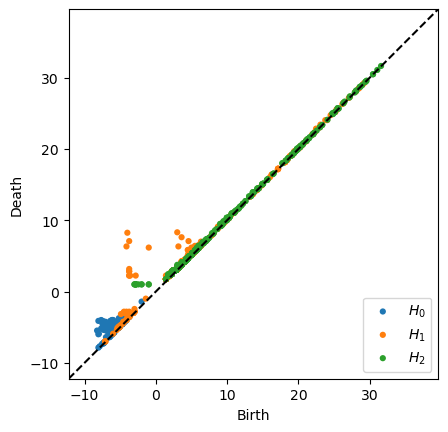

In [163]:
fName='DB12-TOXNIF_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))


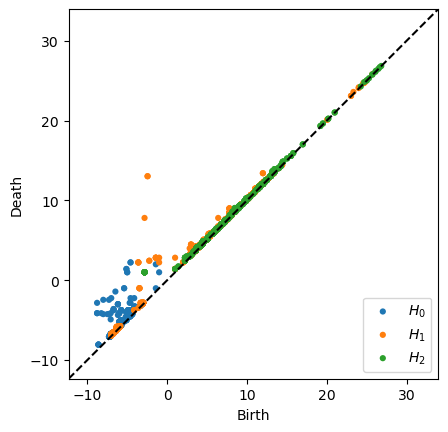

In [105]:
fName='DB12-LOBHAM_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))


### Below are not as good examples (random)

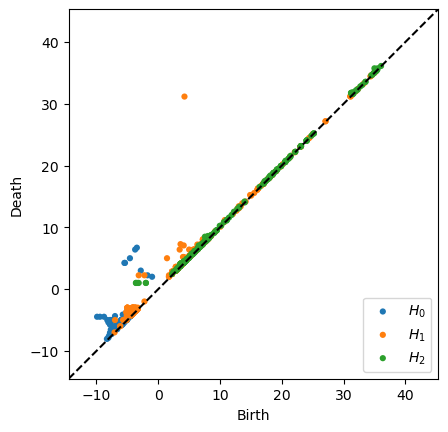

In [164]:
fName='DB5-hypotheticalMOF_5070462_0_0_2_3_16_4'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

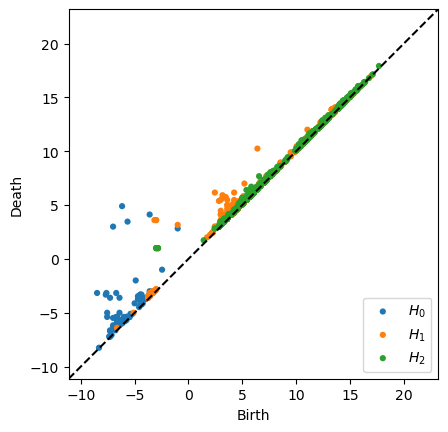

In [165]:

fName='DB0-m3_o22_o23_f0_pcu.sym.30' #1.4,72
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

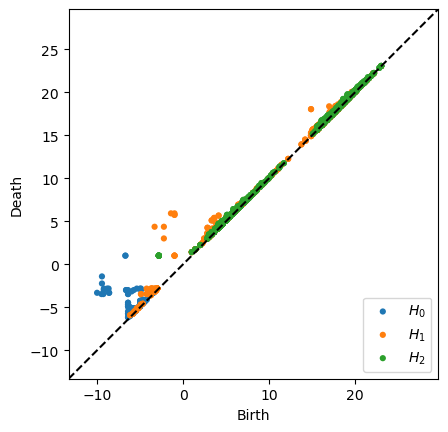

In [108]:
fName='DB12-KAYCIY_clean' #cap around 4, select around 200
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

In [91]:
wDist(selectAll['filename'].iloc(0)[0],subMof['filename'].iloc(0)[0],b=2)


130.07583346871274

In [96]:
bDist(selectAll['filename'].iloc(0)[0],subMof['filename'].iloc(0)[0],b=0)

2.4641016151377544

In [77]:
subMof.head()

,filename,mmol/g_working_capacity,selectivity
7270,DB0-m3_o153_o22_f0_fsc.sym.61,2.397933,166.126460
860,DB12-VULKIX_clean,1.462808,144.082065
5390,DB5-hypotheticalMOF_5055689_1_0_1_28_15_5,0.180313,1.422015
5191,DB0-m3_o14_o22_f0_pcu.sym.99,1.779169,97.214630
11964,DB12-WUXLEI_clean,1.323712,35.411010


In [111]:
bounds={"selectivity":375}

highSel=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [115]:
len(highSel)

70

In [116]:
highSel.head()

,filename,mmol/g_working_capacity,selectivity
310,DB12-XUKLAS_clean,1.611874,503.93475
356,DB12-OQOXAV_clean,1.393388,482.22868
499,DB12-WEMDID_freeONLY,1.645496,495.63376
576,DB12-PEDMOB_freeONLY,1.375536,440.50403
777,DB12-VEHNED_clean,0.576213,495.55399


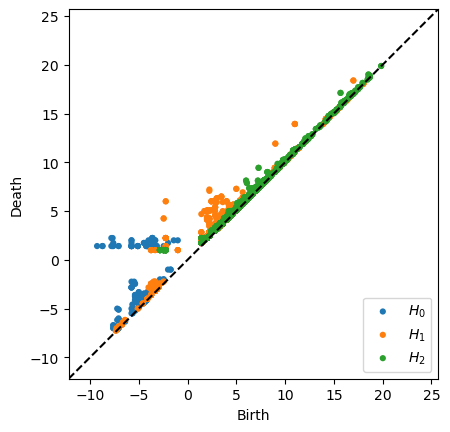

In [117]:
fName='DB12-VEHNED_clean'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

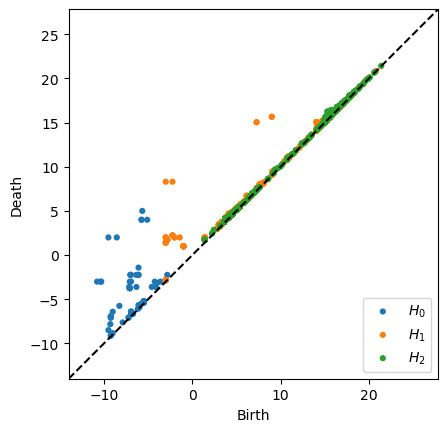

In [118]:
fName='DB12-WEMDID_freeONLY'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

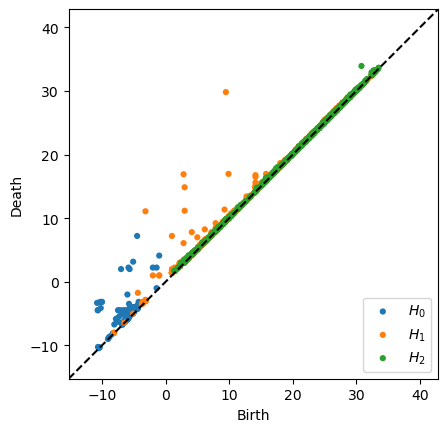

In [160]:

fName='DB5-hypotheticalMOF_5073350_0_0_2_19_8_8'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

In [112]:
bounds={"mmol/g_working_capacity":3.75}

highCap=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [114]:
highCap.head()

,filename,mmol/g_working_capacity,selectivity
87,DB5-hypotheticalMOF_24443_0_0_1_5_9_7,5.785946,225.072265
94,DB0-m3_o17_o114_f0_fsc.sym.53,3.879300,193.270855
187,DB1-Cu2O8N2-AZO_A-DABCO_A_No15,4.466832,107.618930
231,DB15-pcu_N139_E120_opt,5.205740,216.439560
626,DB12-WAMRIN01_clean,5.368655,198.398765


## NAIVE model 1:

Regression, B1: (tThresh0)
- Number and lifetime (intensity) of points that are born below 0
- - high intensity points should increase selectivity
- working cap is affected by number/lifetime of points below 0 (minus -) number/intensity above 0.

In [6]:
b1thresh=[-25,50]
outLifetimeThresh=1
tBins=int(((b1thresh[1]-b1thresh[0])**2+b1thresh[1]-b1thresh[0])/2)
## vectorize:



In [7]:
tBins

2850

In [7]:
def indexMap(b,d,mi,ma,thresh=1):
    ## Let's distinguish from points above and below 0 in the future - for now we are guaranteed that -25 is the true lowest bound

    life = ma - mi +1 # technically b1thresh but let's keep it this way for now & assert type(mi,ma) ==(int,int)
    rows = round((b - mi))
    persist=d - b
    if rows < 0:
        if persist > thresh:
            return 0  # belowPersistent
        else:
            return 2  # belowWeak
    elif rows > life:
        if persist > thresh:
            return 1  # abovePersistent
        else:
            return 3  # aboveWeak
    else:
        if d>ma:
            if persist > thresh:
                return 1 # abovePersistent ---- maybe we should separate into those abovePersistent
                    #with (b<0,b>=0) respectively? --looking at error cases it seems we're lucky and don't have
                    ### to deal with it for now (good bounds)

                    ####Remember, we can always decode the frequency plot (for resolution within bounds)
            else:
                return 3 # aboveWeak
        rowskip = life - rows
        return round(4 + (life * (life + 1) - rowskip * (rowskip + 1)) / 2 + d - b)


In [11]:
mi,ma=b1thresh[0],b1thresh[1]

indexMap(50,49,mi,ma,thresh=1)

2853

In [16]:
indexMap(-25,-25,mi,ma,thresh=1)

4.0

## Time to vectorize -- grab all B1 and we'll throw the intensities into an integer vector of size tBins

# This should be able to be GPU Threaded - so look into this imp

### Vectorize Py  -- just for tThresh0 and B1

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing
from multiprocessing.dummy import Pool


b1thresh = [-25, 50]
outLifetimeThresh = 1
tBins = int(((b1thresh[1] - b1thresh[0]) ** 2 + b1thresh[1] - b1thresh[0]) / 2)

inDir="Z:/data/diverse_metals/diverseTopCSV/tThresh0/B1"
#topTypes=os.listdir(inDir)

outDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"

df=os.listdir(inDir)


def vectorizePH(phCSV, mi, ma, thresh=1, outLifetimeThresh=1):
    b1thresh = [round(mi), round(ma)]
    tBins = int(((b1thresh[1] - b1thresh[0]) ** 2 + b1thresh[1] - b1thresh[0]) / 2)+2
    PHvec = np.zeros(tBins + 4, dtype=np.int32)

    def indexMap(b, d):
        life = ma - mi  # technically b1thresh but let's keep it this way for now & assert type(mi,ma) ==(int,int)
        rows = round((b - mi))
        persist=d - b
        if rows < 0:
            if persist > thresh:
                return 0  # belowPersistent
            else:
                return 2  # belowWeak
        elif rows > life:
            if persist > thresh:
                return 1  # abovePersistent
            else:
                return 3  # aboveWeak
        else:
            if d>ma:
                if persist > thresh:
                    return 1
                else:
                    return 3
            rowskip = life - rows
            return round(4 + (life * (life + 1) - rowskip * (rowskip + 1)) / 2 + d - b)

    with open(phCSV, "r") as f:  ###GPU Parallelize here
        for line in f.readlines():
            b, d = line.split(",")
            PHvec[indexMap(np.float32(b), np.float32(d))] += 1
    return PHvec


def extractVec(mofName):
    PHvec=vectorizePH(f"{inDir}/{mofName}",b1thresh[0],b1thresh[1])
    np.save(f"{outDir}/{mofName[:-3]}npy",PHvec)

ncpus=6
pool=Pool(ncpus)


results=pool.map(extractVec,df)

pool.close()
pool.join()

In [14]:

inDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"
mofFnames= os.listdir(inDir)
for f in mofFnames[:1]:
    a=np.load(f"{inDir}/{f}")

In [18]:
len(a)

2855

In [40]:
b1thresh = [-25, 50]
life=int(b1thresh[1] - b1thresh[0]+1)
tBins = int(4+((life) ** 2 + life) / 2) #[(-mi,-mi)...,(-mi,ma),...(ma,ma)]

inDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"
mofFnames= os.listdir(inDir)
mofPHVec=np.ndarray((len(mofFnames),tBins),dtype=np.int32)

for i in range(len(mofFnames)):
    mofPHVec[i,:]=np.load(f"{inDir}/{mofFnames[i]}")

In [41]:
np.sum(mofPHVec[0])



383

In [9]:
inDir="Z:/data/diverse_metals/diverseTopCSV/tThresh0/B1"
phCSV="DB0-m1_o2_o5_f0_pcu_PH.csv"
mi=-25;ma=50
with open(f"{inDir}/{phCSV}", "r") as f:  ###GPU Parallelize here
    for line in f.readlines():
        b, d = line.split(",")
        print(indexMap(np.float32(b), np.float32(d),mi,ma))

2552
2552
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2434
2434
2434
2434
2434
2434
2434
2434
2402
2402
2402
2402
2402
2402
2402
2369
2369
2335
2335
2335
2335
2335
2335
2339
2339
2337
2337
2227
2150
2150
2110
2110
2110
2110
2069
2069
2069
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1705
1705
1705
1705
1705
1705
1705
1705
1705
1705
1706
1706
1554
1554
1445
1445
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1335
1335
1335
1334
1334
1334
1334


In [36]:
cols=["belowPersistent","abovePersistent","belowWeak","aboveWeak"]
for rows in range(b1thresh[0],b1thresh[1]+1):
    for j in range(b1thresh[1]-rows+1):
        cols.append(f"{rows}_{rows+j}")

In [37]:
cols[-20:]

['45_46',
 '45_47',
 '45_48',
 '45_49',
 '45_50',
 '46_46',
 '46_47',
 '46_48',
 '46_49',
 '46_50',
 '47_47',
 '47_48',
 '47_49',
 '47_50',
 '48_48',
 '48_49',
 '48_50',
 '49_49',
 '49_50',
 '50_50']

In [38]:
len(cols)

2930

In [42]:
phDF=pd.DataFrame(mofPHVec,columns=cols,index=[i[:-7] for i in mofFnames])

In [43]:
phDF.to_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv")

In [4]:
phDF=pd.read_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv",index_col=0)

In [4]:
phDF.head()

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-25_-25,-25_-24,-25_-23,-25_-22,-25_-21,-25_-20,...,47_47,47_48,47_49,47_50,48_48,48_49,48_50,49_49,49_50,50_50
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
phDF.loc[["DB0-m3_o12_o22_f0_pcu.sym.90"]]

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-25_-25,-25_-24,-25_-23,-25_-22,-25_-21,-25_-20,...,47_47,47_48,47_49,47_50,48_48,48_49,48_50,49_49,49_50,50_50
DB0-m3_o12_o22_f0_pcu.sym.90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
[i for i in df.iloc(0) if i['filename']=="DB7-ddmof_7022"]

[filename                   DB7-ddmof_7022
 mmol/g_working_capacity          0.133501
 selectivity                       1.37503
 Name: 3920, dtype: object]

In [53]:
aboveMOF=[i for i,row in phDF.iterrows() if row["abovePersistent"]>0]
aboveMOF

['DB0-m23_o29_o29_f0_pcu',
 'DB0-m2_o19_nog',
 'DB0-m2_o20_nou',
 'DB0-m2_o21_pds',
 'DB0-m2_o27_o27_f0_pcu.sym.22',
 'DB0-m2_o2_mgg',
 'DB0-m2_o35_isx',
 'DB0-m2_o58_o19_zul',
 'DB0-m2_o7_o59_ins_0.359375_CN',
 'DB0-m3_o13_frl',
 'DB0-m3_o19_jsd',
 'DB0-m3_o19_ptr',
 'DB0-m3_o20_o58_tfg',
 'DB0-m3_o21_brl',
 'DB0-m3_o22_uoa',
 'DB0-m3_o23_frl',
 'DB0-m3_o23_uob',
 'DB0-m3_o25_o29_f0_nbo.sym.2',
 'DB0-m3_o25_pcl',
 'DB0-m3_o25_xai',
 'DB0-m3_o27_o27_f0_pcu.sym.13',
 'DB0-m3_o27_o27_f0_pcu.sym.26',
 'DB0-m3_o27_o27_f0_pcu.sym.79',
 'DB0-m3_o28_thj',
 'DB0-m3_o6_frl',
 'DB0-m3_o6_o20_f0_nbo.sym.162',
 'DB0-m3_o6_o23_f0_nbo.sym.163',
 'DB0-m3_o6_ucn',
 'DB0-m3_o8_ucn',
 'DB0-m6_o56_o56_f0_the',
 'DB1-Cu2O8-pcn6_B-TDPAT_No456',
 'DB1-Zn2O8N2-DPAC_A-NiC4_No9',
 'DB1-Zn4O13-irmof7_A-irmof8_A_No434',
 'DB12-KUVMIZ_clean',
 'DB12-RUBDUP_clean',
 'DB12-XIGFOJ_manual',
 'DB13-dia-Syn034005',
 'DB15-dmp_N76_E120_opt',
 'DB15-dmp_N76_E23_opt',
 'DB15-lon_N76_E201_opt',
 'DB15-lon_N76_E23_opt',
 'D

In [67]:
len(aboveMOF)

230

In [ ]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
plt.hist([i["mmol/g_working_capacity"] for i in [df.loc[j] for j in aboveMOF]])
plt.xlabel("mmol/g_working_capacity")

In [73]:
np.max([i["mmol/g_working_capacity"] for i in [df.loc[j] for j in aboveMOF]])

1.243834

(array([6.605e+03, 2.864e+03, 1.654e+03, 7.540e+02, 2.320e+02, 6.000e+01,
        1.700e+01, 9.000e+00, 2.000e+00, 4.000e+00]),
 array([4.3000000e-05, 8.4958110e-01, 1.6991192e+00, 2.5486573e+00,
        3.3981954e+00, 4.2477335e+00, 5.0972716e+00, 5.9468097e+00,
        6.7963478e+00, 7.6458859e+00, 8.4954240e+00]),
 <BarContainer object of 10 artists>)

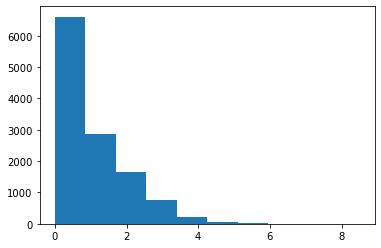

In [72]:
##total
plt.hist([i for i in df["mmol/g_working_capacity"]])

In [66]:
belowMOF=[i for i,row in phDF.iterrows() if row["belowPersistent"]>0]
belowMOF

[]

In [63]:
df.loc[aboveMOF[0]]

mmol/g_working_capacity    0.417868
selectivity                5.376075
Name: DB0-m23_o29_o29_f0_pcu, dtype: float64

In [75]:
# pvalue of drawing n points below 1.25

pAbove=sum([1 for i in df['mmol/g_working_capacity'] if i>1.25])/len(df['mmol/g_working_capacity'])

In [76]:
pAbove

0.3287435456110155

In [11]:
#grab below zero and above zero for now,

# the main hypothesis is that we'll see relevant points as some function of the persistence and it's birth distance away from zero

cols=phDF.columns
belowZero=phDF.iloc[:,:indexMap(1,0,mi,ma,thresh=1)]
aboveZero=phDF.iloc[:,indexMap(1,0,mi,ma,thresh=1):]

In [12]:
assert(len(belowZero.columns)+len(aboveZero.columns)==len(cols)) # let's work with a symmetric system for now ? build a persistence threshold
    #then a range of boxes OR a function of (dist(b,0),b-d)

In [17]:
#should we inverse the hash? Map these points to a set of filenames for later convenience

phMOFmap={k:set() for k in phDF.columns}
for i in phDF.index:
    for k in phDF.columns:
        if phDF.loc[i][k]>0:
            phMOFmap[k].add(i)

In [23]:
f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","wb")
pickle.dump(phMOFmap,f)
f.close()

## phMOFmap is a hash from points in the persistence diagram to the MOFs that have points in that region

In [9]:
f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","rb")
phMOFmap=pickle.load(f)
f.close()

In [ ]:
# color by mean of workingCap - 2SD of all bins, then plot

In [25]:
phMOFmap["50_50"]

{'DB0-m15_o19_nab',
 'DB0-m1_o24_o58_rna',
 'DB0-m1_o25_crs',
 'DB0-m1_o25_o29_f0_pcu',
 'DB0-m1_o25_snk',
 'DB0-m1_o26_stb',
 'DB0-m1_o32_o22_muo',
 'DB0-m1_o59_o3_rna',
 'DB0-m23_o29_o29_f0_pcu',
 'DB0-m2_o14_mou',
 'DB0-m2_o17_o19_f0_nbo.sym.54',
 'DB0-m2_o17_o22_f0_nbo.sym.116',
 'DB0-m2_o19_nog',
 'DB0-m2_o19_ucn',
 'DB0-m2_o20_o24_f0_nbo.sym.23',
 'DB0-m2_o21_pds',
 'DB0-m2_o21_ssd',
 'DB0-m2_o22_o25_f0_nbo.sym.18',
 'DB0-m2_o24_o27_f0_nbo.sym.29',
 'DB0-m2_o27_o27_f0_pcu.sym.31',
 'DB0-m2_o28_o28_f0_pcu.sym.61',
 'DB0-m2_o28_o28_f0_pcu.sym.63',
 'DB0-m2_o2_mgg',
 'DB0-m2_o33_o22_jea',
 'DB0-m2_o35_isx',
 'DB0-m2_o4_o25_f0_nbo.sym.15',
 'DB0-m2_o58_o19_zul',
 'DB0-m2_o58_o23_dme',
 'DB0-m2_o58_o24_dme',
 'DB0-m2_o6_o7_f0_nbo.sym.116',
 'DB0-m2_o7_o59_ins_0.359375_CN',
 'DB0-m3_o19_ptr',
 'DB0-m3_o19_umm',
 'DB0-m3_o1_xai',
 'DB0-m3_o20_o58_tfg',
 'DB0-m3_o21_brl',
 'DB0-m3_o22_o58_dme',
 'DB0-m3_o23_frl',
 'DB0-m3_o23_uob',
 'DB0-m3_o25_o29_f0_nbo.sym.2',
 'DB0-m3_o25_pcl',
 'DB0

In [31]:
phMOFmap["2_30"]

{'DB15-pcu_N123_E155_opt',
 'DB15-pcu_N139_E96_opt',
 'DB15-sxc_N123_E24_opt',
 'DB5-hypotheticalMOF_5039215_1_0_1_15_25_12',
 'DB5-hypotheticalMOF_5052944_1_0_1_27_18_4',
 'DB5-hypotheticalMOF_5056579_0_0_1_29_17_8',
 'DB5-hypotheticalMOF_5058348_0_0_1_29_23_8',
 'DB5-hypotheticalMOF_5065447_1_0_2_16_16_8',
 'DB5-hypotheticalMOF_5066311_0_0_2_8_17_4',
 'DB5-hypotheticalMOF_5071796_0_0_2_19_25_14',
 'DB5-hypotheticalMOF_5071918_1_0_2_19_24_5',
 'DB5-hypotheticalMOF_5074530_0_0_2_23_11_14',
 'DB7-ddmof_17084',
 'DB7-ddmof_22316',
 'DB7-ddmof_3089',
 'DB7-ddmof_3896',
 'DB7-ddmof_4315',
 'DB7-ddmof_5457',
 'DB7-ddmof_5705',
 'DB7-ddmof_6135'}

In [32]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["2_30"]]


In [33]:
[np.mean(subCaps),np.std(subCaps)]

[0.5058317999999999, 0.41734246231297867]

In [34]:
np.max(subCaps)

1.649256

In [42]:
phMOFmap["-5_25"]

{'DB0-m18_o19_o147_f0_pcu',
 'DB0-m1_o16_o31_muo',
 'DB0-m1_o22_o28_f0_pcu',
 'DB0-m1_o32_o22_muo',
 'DB0-m1_o59_o9_ith-d',
 'DB12-CAVPUM_manual',
 'DB12-EPONEE_clean',
 'DB12-ICAROV_clean',
 'DB12-MUWQEB_freeONLY',
 'DB13-dia-Syn036822',
 'DB13-pcu-Syn037810',
 'DB15-cds_N29_E24_opt',
 'DB7-ddmof_16614',
 'DB7-ddmof_20996',
 'DB7-ddmof_21595',
 'DB7-ddmof_22188',
 'DB7-ddmof_22242',
 'DB7-ddmof_22528',
 'DB7-ddmof_23049',
 'DB7-ddmof_23114',
 'DB7-ddmof_23504',
 'DB7-ddmof_3705',
 'DB7-ddmof_3930',
 'DB7-ddmof_4183',
 'DB7-ddmof_5907',
 'DB7-ddmof_6411'}

In [43]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["-4_30"]]
[np.mean(subCaps),np.std(subCaps),np.max(subCaps)]

[0.42630720000000005, 0.49932733135131574, 2.583516]

In [45]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["-10_26"]]
[np.mean(subCaps),np.std(subCaps),np.max(subCaps)]

[0.209858, 0.0, 0.209858]

In [46]:
phMOFmap["-10_26"] # our hope is that this MOF has an incredible amt of persistent points above the thresh to "balance out" for this good point.

{'DB7-ddmof_18943'}

In [47]:
from functools import reduce



set()

In [37]:
np.max(subCaps)

2.583516

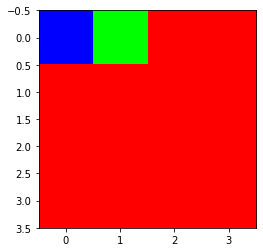

In [52]:
red=(255,0,0)
blue=(0,0,255)
green=(0,255,0)
h,w,channel=4,4,3
im=np.full((h,w,channel),[255,0,0],dtype=np.uint8)
im[0,0]=blue
im[0,1]=green

plt.imshow(im)

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing
from multiprocessing.dummy import Pool
from functools import reduce
import pickle

df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
phDF=pd.read_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv",index_col=0)

f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","rb")
phMOFmap=pickle.load(f)
f.close()


channels=3
red=(255,0,0)
green=(0,255,0)
blue=(0,0,255)
colorCodes={'max':red,'min':blue}


b0thresh=[-25,50]
mi,ma=b0thresh
life=ma-mi
#meanBox=np.zeros((life+1,life+1,channels),dtype='uint8')
meanBox=np.zeros((life+1,life+1),dtype=np.float64)
#varBox=np.zeros((life+1,life+1,channels),dtype='uint8')
varBox=np.zeros((life+1,life+1),dtype=np.float64)

optVar="mmol/g_working_capacity"
boundOpt=[np.min(df[optVar]),np.max(df[optVar])]

def arrayImageIndexMap(b,d,mi,ma):
    return [ma-d,b-mi]




def grabStatsBox(k): ## ie k = "50_50" the key to the associating region in bounding box-
    mi=-25;ma=50

    b,d=[int(i) for i in k.split("_")]
    subset = np.array([df.loc[k][optVar] for k in phMOFmap[k]],dtype=np.float64)
    if len(subset)>0:
        #inds=arrayImageIndexMap(b,d,mi,ma)
        meanBox[ma-d,b-mi]=np.mean(subset)
        if len(subset)>1:
            varBox[ma-d,b-mi]=np.var(subset)



In [13]:
for k in set(phMOFmap.keys())-set(["belowPersistent","abovePersistent","belowWeak","aboveWeak"]):
    grabStatsBox(k)

In [15]:
bounds={"mean":np.max(meanBox),"var":np.max(varBox)}
bounds

{'mean': 4.68975, 'var': 4.7350173440902505}

In [58]:
np.median([i for i in meanBox.flatten() if i!=0]) #too diluted with bad candidates, let's naturally use 2 as the thresh

0.40546290000000007

In [59]:
np.median([i for i in varBox.flatten() if i!=0]) #too diluted with bad candidates, let's naturally use 1 as the thresh


0.15007766140316808

In [99]:
np.median(df['mmol/g_working_capacity'])

0.75396

In [16]:
channels=3
meanBoxColor=np.zeros((life+1,life+1,channels),dtype='uint8')
varBoxColor=np.zeros((life+1,life+1,channels),dtype='uint8')
medBound=1.5#np.median(df['mmol/g_working_capacity'])#np.median([i for i in meanBox.flatten() if i!=0])
varBound=.45


bounds={"mean":np.max(meanBox),"var":np.max(varBox)}
red=np.array((255,0,0),dtype="uint8")
green=np.array((0,255,0),dtype="uint8")
blue=np.array((0,0,255),dtype="uint8")
colorCodes={'max':red,'min':blue}
colorCodesVar={'max':(red+green)*.75,'min':(blue+green)*.5}
for b in np.arange(mi,ma+1):
    for d in np.arange(b,ma+1):
        meanExam=meanBox[ma-d,b-mi]
        if meanExam>0:#np.isclose(meanExam,0):

            if meanExam<medBound: # color blue (bluer candidates closer to 0
                meanBoxColor[ma-d,b-mi,:]=np.round(colorCodes["min"]*(medBound-meanExam)/medBound)
            else:
                meanBoxColor[ma-d,b-mi,:]=np.round(colorCodes["max"]*(meanExam-medBound)/(bounds["mean"]-medBound))

            varExam=varBox[ma-d,b-mi]
            if varExam>0:#not np.isclose(varExam,0):
                if varExam<varBound:
                    varBoxColor[ma-d,b-mi,:]=np.round(colorCodesVar["min"]*(varBound-varExam)/varBound)
                else:
                    varBoxColor[ma-d,b-mi,:]=np.round(green*(varExam-varBound)/(bounds["var"]-varBound))




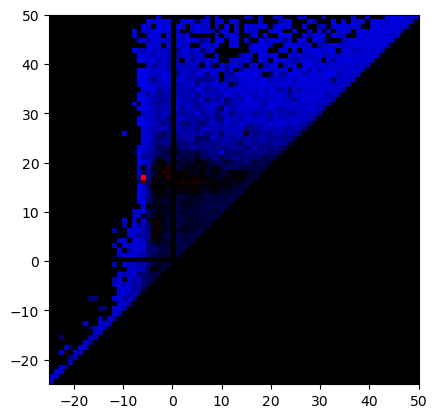

In [17]:
plt.imshow(meanBoxColor,extent=[-25,50,-25,50]) # yay red :)
#grab triangle from [-10,15] and make stepwise regression

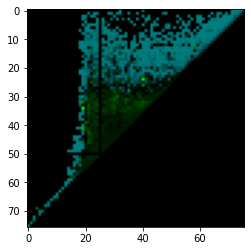

In [100]:
plt.imshow(varBoxColor)

### This code can/should be reused to plot the distribution correlations in B0,B2, and other topological transforms

In [68]:
mi,ma

(-25, 50)

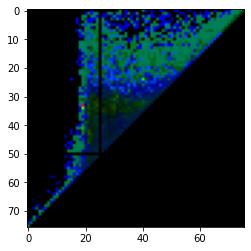

In [103]:
plt.imshow(varBoxColor+meanBoxColor)

In [18]:
phDF=pd.read_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv",index_col=0)

In [19]:
phDF

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-25_-25,-25_-24,-25_-23,-25_-22,-25_-21,-25_-20,...,47_47,47_48,47_49,47_50,48_48,48_49,48_50,49_49,49_50,50_50
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_7235,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
DB7-ddmof_790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB7-ddmof_936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB7-ddmof_96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor

In [31]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
df.head()

,mmol/g_working_capacity,selectivity
filename,,
DB0-m3_o12_o22_f0_pcu.sym.90,0.370563,13.582315
DB0-m3_o16_o460_f0_fsc.sym.19,2.774926,196.043735
DB0-m3_o8_o23_f0_pcu.sym.155,0.531669,8.000730
DB5-hypotheticalMOF_5044966_0_0_1_3_24_6,1.703426,67.395940
DB0-m3_o155_o151_f0_fsc.sym.13,0.937707,26.451195


In [65]:
np.random.seed(42)
dlength=len(df["selectivity"])
labShuf=np.array(range(dlength))
np.random.shuffle(labShuf)

tr,te=.8,.2

trainMOFs=list(df.index[labShuf[:int(np.ceil(tr*dlength))]])
testMOFs=list(df.index[labShuf[int(np.ceil(tr*dlength)):]])

In [67]:
set(selectAll.index) & set(trainMOFs)

{'DB1-Cu2O8N2-irmof6_A_No10',
 'DB1-Zn2O8-fum_A-irmof20_A_No142',
 'DB1-Zn2O8N2-irmof8_A-TePM_No469',
 'DB12-HAFVUH_SL',
 'DB12-IQEKOG_clean',
 'DB12-LOBHAM_clean',
 'DB12-NAWKII_clean',
 'DB12-NEYZAU_clean',
 'DB12-NURMUJ_clean',
 'DB12-TOXNIF_clean',
 'DB12-XESKAJ_clean',
 'DB5-hypotheticalMOF_22163_0_0_1_11_10_13',
 'DB5-hypotheticalMOF_35842_0_0_2_14_1_2',
 'DB5-hypotheticalMOF_5050675_0_0_1_23_3_12',
 'DB5-hypotheticalMOF_5081767_0_0_2_29_1_14'}

In [60]:
df.index[[0,1]]

Index(['DB0-m3_o12_o22_f0_pcu.sym.90', 'DB0-m3_o16_o460_f0_fsc.sym.19'], dtype='object', name='filename')

In [69]:
newThresh=[-11,20]
pBounds=[-25,50]
life=pBounds[1]-pBounds[0]
#phDF.columns[4+(newThresh[0]-pBounds[0])*(newThresh[0]-pBounds[0]+1):]
truncCols=[i for i in phDF.columns[4:] if newThresh[0]<=int(i.split("_")[0])<newThresh[1] and newThresh[0]<=int(i.split("_")[1])<newThresh[1]]

phDFSub=phDF[list(phDF.columns[:4])+list(truncCols)]

In [70]:
phDFSub


,belowPersistent,abovePersistent,belowWeak,aboveWeak,-11_-11,-11_-10,-11_-9,-11_-8,-11_-7,-11_-6,...,16_16,16_17,16_18,16_19,17_17,17_18,17_19,18_18,18_19,19_19
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,39,1,0,0,53,0,0,2,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,7,1,2
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_7235,0,0,0,0,6,0,0,0,0,0,...,473,0,1,0,400,1,1,343,1,265
DB7-ddmof_790,0,0,0,0,0,0,0,0,0,0,...,145,3,0,0,162,2,0,196,2,180
DB7-ddmof_936,0,0,0,0,0,0,0,0,0,0,...,166,0,1,0,152,4,0,132,0,89
DB7-ddmof_96,0,0,0,0,0,0,0,0,0,0,...,193,8,0,0,171,0,0,360,4,239


In [105]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
regVar="mmol/g_working_capacity"#"mmol/g_working_capacity""selectivity"
ytr=[df.loc[ind][regVar] for ind in trainMOFs]

reg=DecisionTreeRegressor(random_state=42)
reg.max_depth=16
reg.fit(phDFSub.loc[trainMOFs],ytr)

DecisionTreeRegressor(max_depth=16, random_state=42)

In [106]:
roundDig=4
print(*((round(i,roundDig),round(j,roundDig)) for i,j in zip(list(reg.predict(phDFSub.loc[testMOFs])),df.loc[testMOFs][regVar])))

(1.6065, 0.5659) (4.1013, 1.5276) (0.3312, 0.5945) (0.6617, 0.3592) (1.053, 0.8074) (1.4203, 0.6479) (0.5032, 0.5556) (1.0897, 0.6882) (0.6063, 0.1367) (0.3312, 0.3453) (2.0726, 1.7692) (0.2902, 0.1684) (0.7524, 0.2399) (0.7077, 1.7558) (2.5388, 2.2813) (0.1537, 0.7407) (0.4178, 0.6184) (0.2776, 0.1766) (0.8047, 0.3501) (0.7077, 1.1615) (0.3257, 0.6012) (0.7267, 1.4392) (0.5804, 0.2396) (0.0784, 1.0763) (1.8403, 2.2893) (0.2858, 0.2685) (2.2204, 1.1096) (1.4203, 3.5321) (3.0365, 1.579) (2.0283, 1.01) (0.5765, 0.0162) (0.2776, 0.2578) (2.6265, 2.2932) (0.7077, 1.485) (0.3312, 0.2155) (0.4358, 0.3593) (1.053, 1.8278) (0.3638, 0.3284) (0.4778, 0.3616) (0.4358, 0.9075) (0.7524, 0.245) (0.5438, 0.4838) (0.255, 0.7243) (0.6826, 1.0107) (0.3706, 0.5653) (1.0035, 3.1612) (2.0726, 2.9756) (0.4358, 0.2316) (1.4445, 1.3521) (0.8075, 1.5918) (0.5765, 0.1892) (1.0897, 1.8931) (2.0571, 1.0387) (0.972, 0.515) (0.7077, 0.29) (0.7524, 0.9904) (0.3319, 0.3714) (2.0963, 0.4267) (0.5765, 0.6188) (3.5176, 

In [86]:
for i in testMOFs:
    print(round(list(reg.predict([phDFSub.loc[i]]))[0],4),round(df.loc[i][regVar],4),i)

#for pred,re in zip(list(reg.predict(phDFSub.loc[testMOFs])),[df.loc[ind][regVar] for ind in testMOFs]):
    #print(pred,re)

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

68.0384 34.4754 DB5-hypotheticalMOF_5046809_2_1_1_19_25_3
73.7938 154.289 DB12-XUCNOZ_clean
13.7431 12.5223 DB0-m3_o16_o27_f0_pcu.sym.92
13.7431 3.0522 DB5-hypotheticalMOF_5063787_1_0_2_15_26_5
79.9771 19.867 DB15-rob_N123_E204_opt
13.7431 24.167 DB0-m3_o24_o28_f0_pcu.sym.105
25.627 13.218 DB0-m2_o12_o25_f0_pcu.sym.66
79.3405 176.4932 DB12-KIYMAI_clean
10.3829 2.5466 DB0-m2_o24_o27_f0_pcu.sym.35
13.7431 8.2473 DB0-m2_o11_o17_f0_pcu.sym.23
79.3405 106.5524 DB0-m3_o440_o4_f0_fsc.sym.29
5.5512 2.4216 DB7-ddmof_5907
13.0839 5.6171 DB0-m2_o22_o23_f0_pcu.sym.17
13.7431 20.0285 DB15-pcu_N65_E65_opt
150.1223 252.8958 DB12-QEWDON_clean
150.1223 153.6754 DB12-BUCPAS_freeONLY
13.7431 13.7264 DB5-hypotheticalMOF_5044525_0_0_1_3_26_5
4.6415 3.1414 DB7-ddmof_22565
13.0839 7.799 DB0-m2_o22_o26_f0_pcu.sym.42
75.8277 60.825 DB0-m3_o10_o12_f0_pcu.sym.77
14.123 8.9602 DB15-pcu_N47_E174_opt
79.3405 193.3536 DB12-HOBGIP_clean
42.7581 6.0093 DB0-m3_o24_o27_f0_pcu.sym.13
76.5977 39.5312 DB0-m3_o540_o6_f0_fsc

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

13.7431 10.083 DB0-m3_o16_o26_f0_pcu.sym.3
10.3829 4.2522 DB0-m2_o11_o12_f0_pcu.sym.69
13.7431 1.4043 DB0-m2_o8_o20_f0_pcu.sym.96
11.9409 25.2622 DB12-WUYXAR_clean
23.7214 17.3466 DB0-m2_o11_o29_f0_pcu.sym.78
147.4342 195.0336 DB0-m3_o10_o16_f0_pcu.sym.20
72.2876 94.6637 DB12-MUQSAU_clean
64.7705 2.4776 DB7-ddmof_18714
10.3829 5.0322 DB0-m3_o24_o26_f0_pcu.sym.21
25.627 23.3501 DB0-m3_o4_o26_f0_pcu.sym.7
151.8148 61.1339 DB12-VOQWUV_clean
150.1223 337.841 DB12-cg500975j_si_002_clean
155.1842 178.5765 DB12-IKAYAU_clean
42.7581 108.5515 DB0-m3_o1490_o155_f0_fsc.sym.4
157.319 169.5388 DB12-ADODUU_freeONLY
5.5512 6.7849 DB7-ddmof_23782
21.6935 16.2989 DB0-m2_o14_o26_f0_pcu.sym.19
13.7431 12.0377 DB0-m3_o14_o21_f0_pcu.sym.22
75.8277 6.1077 DB12-BOCTOE02_clean
95.6184 97.437 DB12-WIVVII_clean
21.6935 2.2949 DB0-m3_o7_o15_f0_pcu.sym.23
35.6495 37.344 DB5-hypotheticalMOF_33273_0_0_2_0_11_4
10.3829 28.9075 DB0-m3_o12_o27_f0_pcu.sym.52
2.3315 3.0318 DB0-m2_o28_o28_f0_pcu.sym.16
75.8277 5.7474 DB1

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

13.7431 30.1814 DB0-m3_o146_o158_f0_fsc.sym.27
35.821 8.7112 DB7-ddmof_5770
2.3315 2.039 DB7-ddmof_21806
10.3829 3.5219 DB0-m3_o12_o13_f0_pcu.sym.18
72.294 116.9826 DB12-KONFIE_freeONLY
65.6855 248.2992 DB1-ZIFZn-BDC_A-irmof6_A_No303
14.2086 15.207 DB7-ddmof_21705
13.6498 3.4202 DB0-m1_o16_o31_muo
97.7348 121.7858 DB5-hypotheticalMOF_7548_0_0_0_11_4_6
4.6415 12.9025 DB7-ddmof_6329
27.3838 35.8771 DB0-m2_o11_o19_f0_pcu.sym.68
13.7431 5.0727 DB0-m2_o3_o24_f0_pcu.sym.57
13.7431 2.1136 DB5-hypotheticalMOF_28341_1_0_2_21_17_7
103.2111 170.2545 DB0-m3_o101_o22_f0_fsc.sym.9
103.2111 3.7637 DB5-hypotheticalMOF_5069967_0_0_2_3_1_3
42.7581 58.7516 DB12-GONTAG_clean
150.1223 363.7585 DB12-RIPNUB_clean
10.0945 54.5391 DB0-m2_o10_o19_f0_pcu.sym.33
14.123 1.925 DB5-hypotheticalMOF_5034387_2_0_1_12_25_3
14.123 57.0077 DB0-m3_o52_o156_f0_fsc.sym.22
71.421 53.3873 DB0-m2_o24_o25_f0_pcu.sym.110
5.5512 4.6558 DB5-hypotheticalMOF_3001032_1_0_1_34_34_5
75.2242 165.6177 DB12-HOTWUJ_clean
16.5043 6.6669 DB0-

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

36.1668 7.6152 DB0-m3_o24_o26_f0_pcu.sym.8
150.1223 230.1439 DB12-YINCOP_clean
169.1545 0.4059 DB12-ASALIP_clean
13.7431 13.0333 DB15-pcu_N139_E112_opt
14.123 3.9047 DB12-YARYEV_freeONLY
25.627 7.1813 DB5-hypotheticalMOF_5036037_1_0_1_18_7_2
155.5097 617.546 DB12-HEKTUO_clean
133.0246 72.5836 DB12-HUCWUZ_clean
75.8277 8.4789 DB5-hypotheticalMOF_5060919_0_0_2_18_9_8
97.7348 50.4947 DB0-m2_o16_o18_f0_pcu.sym.42
211.5904 138.4101 DB0-m3_o152_o22_f0_fsc.sym.75
45.6836 51.2876 DB0-m2_o16_o17_f0_pcu.sym.56
13.7431 2.0008 DB7-ddmof_5107
147.4342 136.5955 DB12-VASKOR_freeONLY
35.6495 1.4589 DB5-hypotheticalMOF_5064728_2_0_2_15_10_8
13.7431 4.3212 DB1-Zn2O8-ADC_A-irmof8_A_No1
2.3315 3.4344 DB0-m3_o23_uob
10.3829 5.5011 DB0-m2_o11_o12_f0_pcu.sym.100
73.7741 48.035 DB12-ROQVIE_freeONLY
75.0593 30.3369 DB0-m3_o24_o26_f0_pcu.sym.77
2.3315 0.9342 DB7-ddmof_23656
150.1223 219.0612 DB12-DORYUG_freeONLY
45.6836 19.5388 DB0-m23_o21_o153_f0_pcu
10.3829 40.4748 DB0-m3_o10_o11_f0_pcu.sym.57
10.7193 19.9278

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

75.8277 86.0685 DB0-m3_o24_o149_f0_fsc.sym.27
186.9865 86.297 DB15-pcu_N65_E217_opt
85.5879 70.1083 DB0-m2_o18_o23_f0_pcu.sym.102
35.6495 4.6972 DB0-m2_o10_o20_f0_pcu.sym.40
30.346 301.0458 DB5-hypotheticalMOF_5034984_1_1_1_12_11_9
97.7348 100.4252 DB12-UMEHOL_clean
233.1182 184.977 DB0-m3_o1530_o4_f0_fsc.sym.17
36.1668 43.7129 DB0-m2_o10_o26_f0_pcu.sym.9
97.7348 127.6365 DB12-HUFYIS_clean
13.7431 38.1103 DB15-sxb_N65_E66_opt
103.2111 163.3418 DB0-m3_o88_o22_f0_fsc.sym.34
14.1642 39.5192 DB12-ROCZUG_clean
25.627 48.215 DB5-hypotheticalMOF_5060619_0_0_2_12_14_7
38.0261 9.9167 DB0-m3_o24_o27_f0_pcu.sym.107
14.123 179.8748 DB0-m3_o12_o118_f0_fsc.sym.8
25.627 142.9006 DB0-m3_o530_o22_f0_fsc.sym.47
5.5512 5.1712 DB0-m2_o24_o29_f0_nbo.sym.51
65.7631 137.259 DB5-hypotheticalMOF_5074938_2_2_2_23_12_0
35.6495 115.0586 DB0-m3_o440_o18_f0_fsc.sym.40
13.7431 5.8902 DB0-m1_o4_o30_mcn
68.6606 306.6373 DB12-HOFSUS_clean
23.7214 9.5404 DB13-lvt-Syn038914
71.1594 28.9692 DB0-m2_o12_o13_f0_pcu.sym.22
79

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

DB0-m2_o17_o21_f0_pcu.sym.65
133.6206 234.8751 DB1-Cu2O8N2-irmof7_A-irmof8_A_No342
79.3405 8.0508 DB12-GAMTOE_clean
279.9831 185.8436 DB5-hypotheticalMOF_6001962_0_0_3_8_9_7
35.6495 65.9434 DB5-hypotheticalMOF_22774_0_0_1_0_11_5
79.3405 97.6524 DB1-ZIFZn-BDC_A-irmof6_A_No72
35.6495 22.7777 DB0-m3_o24_o440_f0_fsc.sym.13
63.1067 22.6331 DB0-m3_o24_o27_f0_pcu.sym.47
10.3829 17.0084 DB0-m2_o12_o13_f0_pcu.sym.90
73.7741 32.1436 DB12-ZIMLIS_clean
21.6935 5.7013 DB0-m2_o13_o23_f0_pcu.sym.18
305.2773 19.3524 DB12-HOTFED_clean
107.9777 7.7605 DB12-TUMGOX_clean
233.9364 22.8434 DB12-USUPUV_clean
150.1223 36.1252 DB12-TADCAE_clean
95.199 44.9659 DB12-OKILEA_clean
42.7581 19.3777 DB0-m3_o12_o16_f0_pcu.sym.13
13.7431 4.9888 DB0-m3_o2_o14_f0_pcu.sym.6
16.8266 8.1168 DB7-ddmof_16461
10.3829 2.2899 DB0-m3_o8_o13_f0_pcu.sym.30
276.0149 54.5218 DB5-hypotheticalMOF_5044362_1_0_1_3_9_2
8.52 7.9769 DB12-GELVEZ02_clean
85.5879 314.9997 DB12-TUMQOJ_clean
155.5097 196.2696 DB12-WOJZOM_clean
10.038 56.1977 DB1

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

75.8277 188.6769 DB0-m3_o51_o22_f0_fsc.sym.11
25.627 49.2295 DB0-m3_o12_o23_f0_pcu.sym.163
150.1223 137.1822 DB12-acs.inorgchem.6b00894_ic6b00894_si_003_freeONLY
13.7431 5.1182 DB0-m2_o15_o27_f0_nbo.sym.38
2.3315 6.7321 DB7-ddmof_23114
21.7917 18.7901 DB5-hypotheticalMOF_22733_0_0_1_0_10_4
13.6498 8.4632 DB7-ddmof_557
1.8183 7.4081 DB1-Cu2O8N2-ADC_A-irmof20_A_No679
103.2111 42.2066 DB0-m3_o12_o22_f0_pcu.sym.109
73.7741 59.7871 DB0-m3_o17_o530_f0_fsc.sym.9
36.1668 11.9853 DB0-m2_o12_o28_f0_pcu.sym.49
37.62 59.7815 DB0-m2_o22_o23_f0_pcu.sym.55
5.5512 7.3332 DB5-hypotheticalMOF_3001053_1_0_1_34_34_4
147.4342 131.2135 DB0-m3_o24_o1530_f0_fsc.sym.46
126.8215 1.6534 DB13-dia-Syn038857
13.7431 42.4575 DB0-m3_o11_o28_f0_pcu.sym.19
120.8915 114.7866 DB0-m9_o13_o22_f0_sra.sym.72
13.7431 5.9307 DB0-m2_o8_o22_f0_pcu.sym.112
35.6495 1.7736 DB5-hypotheticalMOF_5039716_1_0_1_15_11_7
13.7431 2.5836 DB0-m2_o11_o21_f0_pcu.sym.11
16.5043 3.1773 DB0-m2_o7_o13_f0_pcu.sym.26
5.5512 4.1944 DB0-m2_o17_o29_f0_

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

 6.2242 DB0-m2_o12_o13_f0_pcu.sym.53
14.123 0.8288 DB12-TIRHIL_clean
107.9777 71.4703 DB0-m2_o24_o105_f0_fsc
25.627 30.141 DB0-m3_o24_o27_f0_pcu.sym.88
107.9777 171.9359 DB0-m3_o22_o47_f0_fsc.sym.43
205.0256 100.6812 DB12-EQOCES_clean
14.2086 11.7407 DB7-ddmof_22390
4.6415 3.3152 DB0-m3_o22_o58_dme
97.7348 39.9304 DB0-m9_o19_o24_f0_sra.sym.95
249.503 98.3646 DB12-MUTDIQ_freeONLY
21.6935 2.5748 DB0-m2_o17_o25_f0_pcu.sym.105
147.4342 78.7891 DB12-OXITOF_clean
13.7431 2.472 DB5-hypotheticalMOF_5046842_1_0_1_19_25_5
75.7248 85.0729 DB0-m3_o24_o520_f0_fsc.sym.29
13.0839 30.5908 DB12-cg401887b_si_004_clean
10.3829 1.7423 DB0-m3_o8_o22_f0_pcu.sym.27
76.4649 82.6086 DB0-m3_o155_o1470_f0_fsc.sym.10
37.3387 69.2444 DB0-m3_o96_o14_f0_fsc.sym.65
40.0671 13.4896 DB12-TISNEQ_clean
226.3022 36.2307 DB0-m2_o12_o13_f0_pcu.sym.32
14.123 1.8644 DB5-hypotheticalMOF_3603_1_0_0_24_2_2
13.7431 1.6238 DB0-m2_o3_o29_f0_pcu.sym.69
78.3495 13.198 DB12-DUYVEA_clean
104.102 41.8947 DB12-EMUBIZ_clean
16.5043 33.708

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

79.3405 75.1879 DB12-HOZDIL_clean
42.7581 85.6545 DB0-m3_o24_o520_f0_fsc.sym.40
75.8277 164.5897 DB0-m3_o90_o22_f0_fsc.sym.12
14.123 1.2817 DB12-QUTVIM_clean
14.123 0.7214 DB5-hypotheticalMOF_5036720_3_0_1_18_24_3
14.123 72.6171 DB5-hypotheticalMOF_5059817_1_0_2_12_1_5
75.8277 20.82 DB0-m3_o24_o51_f0_fsc.sym.17
97.7348 81.6573 DB0-m2_o16_o16_f0_pcu.sym.22
160.8211 27.1764 DB12-HILJUJ_freeONLY
25.627 38.0645 DB0-m2_o16_o28_f0_pcu.sym.82
44.1139 33.5724 DB1-Al2O6-AZO_B-TED_B_No6
85.5879 153.8179 DB0-m3_o88_o22_f0_fsc.sym.3
43.7476 77.6405 DB15-qtz-x_N123_E13_opt
38.6631 56.5524 DB12-WUZDOL_clean
13.7431 3.0738 DB5-hypotheticalMOF_5034481_0_0_1_12_25_8
150.1223 83.6489 DB12-YEKWOC_clean
13.7431 1.2015 DB5-hypotheticalMOF_5007656_1_0_0_15_11_8
75.8277 77.5582 DB0-m3_o17_o153_f0_fsc.sym.19
13.7431 6.8137 DB0-m2_o13_o24_f0_pcu.sym.23
147.4342 96.8292 DB0-m9_o1_o4_f0_sra.sym.55
42.9451 24.7327 DB12-EQUBUO_freeONLY
248.5253 162.8193 DB12-QADXAX_clean
13.7431 2.1181 DB5-hypotheticalMOF_5059735_

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

 5.6204 DB0-m3_o14_o20_f0_pcu.sym.13
88.8477 34.5104 DB13-nbo-Syn035780
97.7348 42.3034 DB0-m3_o1_o25_f0_pcu.sym.74
150.1223 80.3983 DB12-DOCKOW_freeONLY
10.3829 2.7498 DB0-m3_o11_o21_f0_pcu.sym.10
13.6498 3.7327 DB7-ddmof_936
13.7431 4.8274 DB5-hypotheticalMOF_5077352_1_0_2_27_22_5
97.7348 53.7056 DB5-hypotheticalMOF_5034609_1_1_1_12_24_8
42.7581 14.3733 DB5-hypotheticalMOF_17968_1_0_1_21_7_4
13.7431 2.9059 DB0-m3_o12_o20_f0_pcu.sym.88
230.2788 222.4153 DB12-DIBPIP_clean
97.7348 128.9331 DB12-TENLIJ_freeONLY
150.1223 128.8962 DB12-BUWMEN_freeONLY
225.1433 305.7401 DB12-YOQLAT_clean
13.7431 1.2997 DB0-m2_o8_o22_f0_pcu.sym.26
13.7431 1.9996 DB5-hypotheticalMOF_5021180_1_0_0_23_13_8
86.8771 221.503 DB12-RUWWOW01_freeONLY
2.3315 4.5852 DB7-ddmof_15828
42.7581 75.6185 DB0-m3_o520_o13_f0_fsc.sym.67
2.3315 3.3626 DB7-ddmof_15258
13.7431 10.5412 DB0-m2_o13_o16_f0_pcu.sym.73
233.9364 208.0609 DB12-NACYUM_clean
13.7431 2.9129 DB15-kag_N47_E27_opt
10.3829 46.931 DB0-m3_o10_o11_f0_pcu.sym.109
14.

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

34.8686 34.4017 DB5-hypotheticalMOF_5082683_0_0_2_29_8_5
75.8277 2.7689 DB12-BEXREC_clean
52.4498 58.6327 DB5-hypotheticalMOF_5074465_2_1_2_23_10_6
75.0593 134.5216 DB0-m3_o153_o22_f0_fsc.sym.39
10.3829 7.7868 DB0-m2_o10_o19_f0_pcu.sym.25
10.1857 2.8759 DB7-ddmof_20599
107.9777 300.4405 DB12-CUZBUW_clean
23.3883 4.4633 DB0-m2_o10_o20_f0_pcu.sym.11
21.6935 49.3149 DB0-m2_o12_o15_f0_pcu.sym.6
13.7431 14.4181 DB0-m3_o11_o28_f0_pcu.sym.85
10.3829 10.0162 DB0-m3_o12_o28_f0_pcu.sym.82
208.5686 0.5458 DB12-TEBCEK_clean
62.1092 384.4924 DB12-ARUYES_clean
163.6092 26.0488 DB0-m2_o11_o25_f0_pcu.sym.106
14.123 66.4217 DB0-m3_o155_o540_f0_fsc.sym.39
2.3315 2.9208 DB5-hypotheticalMOF_5020013_1_0_0_23_26_8
150.1223 75.376 DB1-Cu2O8N2-irmof6_A-NiC4_No2
10.3829 3.4798 DB0-m2_o17_o26_f0_pcu.sym.73
16.5043 13.8062 DB0-m3_o24_o28_f0_pcu.sym.27
76.5977 164.4212 DB0-m3_o22_o47_f0_fsc.sym.71
150.1223 133.1931 DB12-JADBIC_freeONLY
79.3405 105.2038 DB5-hypotheticalMOF_5070951_0_0_2_3_8_5
243.3243 1.5801 DB12-

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: U

In [72]:
reg.predict([phDFSub.loc['DB12-TAKTIL_clean']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([6.081177])

In [73]:
reg.predict([phDFSub.loc['DB12-IQEKOG_clean']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([5.701334])

In [46]:
reg.predict([phDFSub.loc['DB12-LOBHAM_clean']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([5.786555])

In [50]:

df = pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv", index_col=0)
regVar = "selectivity"
y = [df.loc[ind][regVar] for ind in phDFSub.index]

reg = DecisionTreeRegressor(random_state=42)
reg.max_depth = 10
reg.fit(phDFSub, y)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [51]:
reg.predict([phDFSub.loc['DB12-LOBHAM_clean']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([309.53987])

In [52]:
reg.predict([phDFSub.loc['DB5-hypotheticalMOF_22163_0_0_1_11_10_13']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([294.314235])

In [53]:

reg.predict([phDFSub.loc['DB0-m3_o96_o11_f0_fsc.sym.9']])

C:\Users\moore\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([14.35275501])

In [59]:
print(sklearn.tree.export_text(reg))

|--- feature_220 <= 29.50
|   |--- feature_118 <= 0.50
|   |   |--- feature_371 <= 1.50
|   |   |   |--- feature_202 <= 0.50
|   |   |   |   |--- feature_391 <= 15.50
|   |   |   |   |   |--- feature_205 <= 2.50
|   |   |   |   |   |   |--- feature_220 <= 14.50
|   |   |   |   |   |   |   |--- feature_226 <= 1.50
|   |   |   |   |   |   |   |   |--- feature_363 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_384 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [25.40]
|   |   |   |   |   |   |   |   |   |--- feature_384 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [205.32]
|   |   |   |   |   |   |   |   |--- feature_363 >  0.50
|   |   |   |   |   |   |   |   |   |--- feature_360 <= 1.00
|   |   |   |   |   |   |   |   |   |   |--- value: [531.08]
|   |   |   |   |   |   |   |   |   |--- feature_360 >  1.00
|   |   |   |   |   |   |   |   |   |   |--- value: [69.94]
|   |   |   |   |   |   |   |--- feature_226 >  1.50
|   |   |   |   |   |   |   |   

In [ ]:
# we need a convolutional NN over the boundary space.